Make sure to change the runtime to GPU
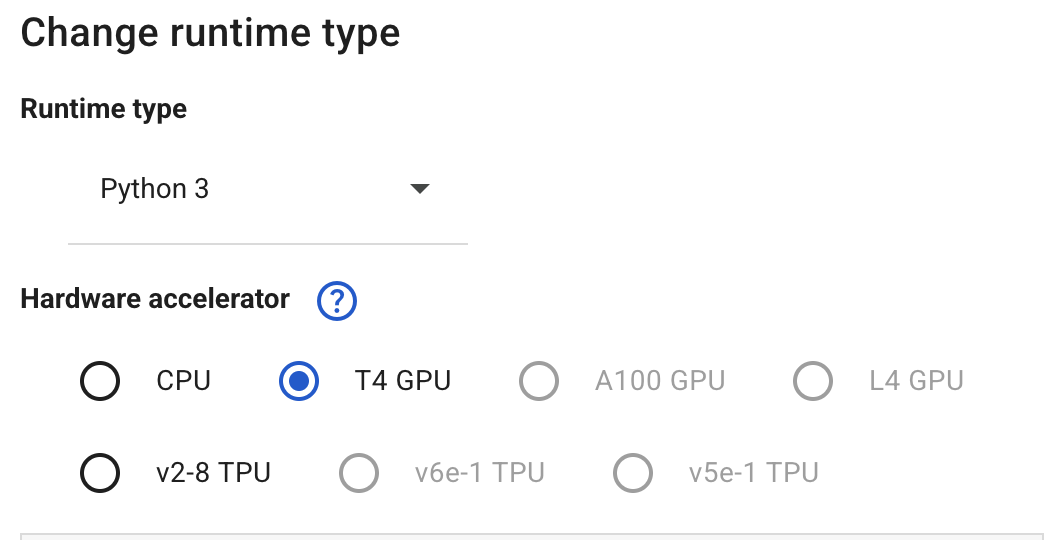



In [1]:
# Install PyCUDA
# uncomment and install pycuda if you do not have it already
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 10.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660427 sha256=979767ed3a21801fba7e61858d46f83b20acd320753b5eed8441ae9d5a713663
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda


In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import time

# --- CUDA Kernel for Keccak-f[1600] ---
cuda_code = """
#include <stdint.h>

#define ROL64(a, offset) (((a) << offset) | ((a) >> (64 - offset)))

__device__ __constant__ uint64_t keccakf_rndc[24] = {
  0x0000000000000001ULL, 0x0000000000008082ULL,
  0x800000000000808aULL, 0x8000000080008000ULL,
  0x000000000000808bULL, 0x0000000080000001ULL,
  0x8000000080008081ULL, 0x8000000000008009ULL,
  0x000000000000008aULL, 0x0000000000000088ULL,
  0x0000000080008009ULL, 0x000000008000000aULL,
  0x000000008000808bULL, 0x800000000000008bULL,
  0x8000000000008089ULL, 0x8000000000008003ULL,
  0x8000000000008002ULL, 0x8000000000000080ULL,
  0x000000000000800aULL, 0x800000008000000aULL,
  0x8000000080008081ULL, 0x8000000000008080ULL,
  0x0000000080000001ULL, 0x8000000080008008ULL
};

__device__ __constant__ int keccakf_rotc[25] = {
     0,  1, 62, 28, 27,
    36, 44,  6, 55, 20,
     3, 10, 43, 25, 39,
    41, 45, 15, 21,  8,
    18,  2, 61, 56, 14
};

__device__ __constant__ int keccakf_piln[25] = {
     0,  6, 12, 18, 24,
     3,  9, 10, 16, 22,
     1,  7, 13, 19, 20,
     4,  5, 11, 17, 23,
     2,  8, 14, 15, 21
};

__device__ void keccakf(uint64_t *st) {
    int i, j, round;
    uint64_t t, bc[5];

    for (round = 0; round < 24; round++) {
        for (i = 0; i < 5; i++)
            bc[i] = st[i] ^ st[i + 5] ^ st[i + 10] ^ st[i + 15] ^ st[i + 20];
        for (i = 0; i < 5; i++) {
            t = bc[(i + 4) % 5] ^ ROL64(bc[(i + 1) % 5], 1);
            for (j = 0; j < 25; j += 5)
                st[j + i] ^= t;
        }

        t = st[1];
        for (i = 0; i < 24; i++) {
            j = keccakf_piln[i];
            bc[0] = st[j];
            st[j] = ROL64(t, keccakf_rotc[i]);
            t = bc[0];
        }

        for (j = 0; j < 25; j += 5) {
            for (i = 0; i < 5; i++) bc[i] = st[j + i];
            for (i = 0; i < 5; i++)
                st[j + i] ^= (~bc[(i + 1) % 5]) & bc[(i + 2) % 5];
        }

        st[0] ^= keccakf_rndc[round];
    }
}

extern "C" __global__ void keccak256_hash(uint64_t *input, uint64_t *output, int num_inputs) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= num_inputs) return;

    uint64_t state[25] = {0};
    state[0] = input[idx]; // Absorb input

    keccakf(state);       // Permute state

    output[idx] = state[0]; // Squeeze output (first 64 bits of digest)
}
"""

mod = SourceModule(cuda_code)
keccak_hash_gpu = mod.get_function("keccak256_hash")

# --- GPU Wrapper ---
def sha3_keccak_gpu(inputs):
    inputs = np.asarray(inputs, dtype=np.uint64)
    output = np.zeros_like(inputs, dtype=np.uint64)

    input_gpu = cuda.mem_alloc(inputs.nbytes)
    output_gpu = cuda.mem_alloc(output.nbytes)

    cuda.memcpy_htod(input_gpu, inputs)

    block_size = 256
    grid_size = (len(inputs) + block_size - 1) // block_size
    keccak_hash_gpu(
        input_gpu, output_gpu, np.int32(len(inputs)),
        block=(block_size, 1, 1), grid=(grid_size, 1)
    )

    cuda.memcpy_dtoh(output, output_gpu)
    return output

# --- CPU Hasher ---
def sha3_keccak_cpu(x):
    x ^= 0xA3A3A3A3A3A3A3A3
    x = ((x << 1) | (x >> 63)) & 0xFFFFFFFFFFFFFFFF
    x ^= (x << 13) & 0xFFFFFFFFFFFFFFFF
    x ^= (x >> 7)
    x ^= (x << 17) & 0xFFFFFFFFFFFFFFFF
    return x & 0xFFFFFFFFFFFFFFFF

# --- Merkle Tree Construction ---
def build_merkle_tree(hashed_leaves, hash_func):
    tree = [hashed_leaves]
    current = hashed_leaves
    while len(current) > 1:
        next_level = []
        for i in range(0, len(current), 2):
            l = current[i]
            r = current[i + 1] if i + 1 < len(current) else l
            combined = np.array([l ^ r], dtype=np.uint64)
            hashed = hash_func(combined)[0]
            next_level.append(hashed)
        current = np.array(next_level, dtype=np.uint64)
        tree.append(current)
    return tree

def get_merkle_root(tree):
    return tree[-1][0]

def generate_proof(index, tree):
    proof = []
    for level in tree[:-1]:
        sibling = index ^ 1
        if sibling < len(level):
            proof.append(level[sibling])
        index //= 2
    return proof

def verify_proof(leaf, proof, root, index, hash_func):
    current = leaf
    for sibling in proof:
        combined = np.array([current ^ sibling], dtype=np.uint64)
        current = hash_func(combined)[0]
        index //= 2
    return current == root

# --- Benchmarking ---
if __name__ == "__main__":
    leaves = np.arange(1000000, dtype=np.uint64)

    # CPU Benchmark
    start = time.time()
    cpu_hashes = np.array([sha3_keccak_cpu(x) for x in leaves], dtype=np.uint64)
    cpu_time = time.time() - start
    print("CPU Time:", cpu_time)

    # GPU Benchmark
    start = time.time()
    gpu_hashes = sha3_keccak_gpu(leaves)
    gpu_time = time.time() - start
    print("GPU Time:", gpu_time)

    # Small Merkle Tree Example
    test_leaves = np.array([i + 1000 for i in range(8)], dtype=np.uint64)
    hashed_leaves = sha3_keccak_gpu(test_leaves)
    tree = build_merkle_tree(hashed_leaves, sha3_keccak_gpu)
    root = get_merkle_root(tree)
    print("Merkle Root:", hex(root))

    # Proof verification
    index = 4
    leaf = hashed_leaves[index]
    proof = generate_proof(index, tree)
    valid = verify_proof(leaf, proof, root, index, sha3_keccak_gpu)
    print(f"Merkle Proof valid (GPU): {valid}")


CPU Time: 1.014375925064087
GPU Time: 0.09377408027648926
Merkle Root: 0xe43d978a33db853a
Merkle Proof valid (GPU): True
